<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/patent_data_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scann -q

In [3]:
import os 
import json
from typing import List
import collections
import numpy as np
import pandas as pd
import scann
import joblib
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
biotech_patents_dir = 'drive/MyDrive/transfer/patent/vec_vectorized_biotech_patents_transformed_ols.json'
uspto_patents_dir = 'drive/MyDrive/transfer/patent/vec_vectorized_uspto_patents_transformed_ols.json'
nih_patents_dir = 'drive/MyDrive/transfer/patent/patent_raw/nih/nih_patents_ada_embeddings.json'

In [5]:
# with open(nih_patents_dir, 'r') as f:
#     data = json.load(f)

In [6]:
class patent_data:
    def __init__(self, dir:str):
        self.dir = dir

    def ab_title_bringer(self):
        with open (self.dir, 'r') as f:
            data = json.load(f)

        title = [data[i]['title'] for i in range(len(data))]
        abstract = [data[i]['abstract'] for i in range(len(data))]
        urls = [data[i]['url'] for i in range(len(data))]

        return title, abstract, urls

def unique_values(x: List[str]) -> List[int] :
    dup = [item for item, count in collections.Counter(x).items() if count > 1]
    unique_pos = []
    for i in dup:
        unique_pos.append(x.index(i))
    
    return(unique_pos)
    
def normalizer(str_data:str) -> str:
    return str_data.lower().rstrip().lstrip()

In [7]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit , mrr  

In [8]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save('./patent_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save('./patent_title_vectors_norm'+pca_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = svd_.inverse_transform(content_vectors_svd)
    inverse_title = svd_.inverse_transform(title_vectors_svd)

    np.save('./patent_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save('./patent_title_vectors_norm'+svd_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

In [9]:
biotech_data = patent_data(biotech_patents_dir)
biotech_title, biotech_abstract,biotech_urls = biotech_data.ab_title_bringer()

uspto_data = patent_data(uspto_patents_dir)
uspto_title, uspto_abstract, biotech_urls = uspto_data.ab_title_bringer()

nih_data = patent_data(nih_patents_dir)
nih_title, nih_abstract, biotech_urls = nih_data.ab_title_bringer()

In [10]:
# biotech_title

In [11]:
normalized_title_biotech = [normalizer(i) for i in biotech_title]
normalized_abstract_biotech = [normalizer(i) for i in biotech_abstract]

normalized_title_uspto = [normalizer(i) for i in uspto_title]
normalized_abstract_uspto = [normalizer(i) for i in uspto_abstract]

normalized_title_nih = [normalizer(i) for i in nih_title]
normalized_abstract_nih = [normalizer(i) for i in nih_abstract]

In [12]:
print('Title BIOTECH PATENTS :',len(normalized_title_biotech))
print('Unique titles BIOTECH PATENTS :',len(set(normalized_title_biotech)))
print('Title USPTO patents :',len(normalized_title_uspto))
print('Unique titles USPTO patents :',len(set(normalized_title_uspto)))
print('Title NIH PATENTS :',len(normalized_title_nih))
print('Unique titles NIH PATENTS :',len(set(normalized_title_nih)))

Title BIOTECH PATENTS : 484
Unique titles BIOTECH PATENTS : 228
Title USPTO patents : 4
Unique titles USPTO patents : 4
Title NIH PATENTS : 3243
Unique titles NIH PATENTS : 2842


In [13]:
print('Title BIOTECH PATENTS :',len(normalized_abstract_biotech))
print('Unique titles BIOTECH PATENTS :',len(set(normalized_abstract_biotech)))
print('Title USPTO patents :',len(normalized_abstract_uspto))
print('Unique titles USPTO patents :',len(set(normalized_abstract_uspto)))
print('Title NIH PATENTS :',len(normalized_abstract_nih))
print('Unique titles NIH PATENTS :',len(set(normalized_abstract_nih)))

Title BIOTECH PATENTS : 484
Unique titles BIOTECH PATENTS : 231
Title USPTO patents : 4
Unique titles USPTO patents : 4
Title NIH PATENTS : 3243
Unique titles NIH PATENTS : 2865


In [14]:
unique_pos_biotech = unique_values(normalized_title_biotech)
unique_pos_uspto = unique_values(normalized_title_uspto)
unique_pos_nih = unique_values(normalized_title_nih)
# np.where( np.array(normalized_title_nih) == 'selective recovery')

In [15]:
biotech_ada_title = np.load('drive/MyDrive/transfer/patent/biotech_title_vectors.npy')
biotech_ada_abstract = np.load('drive/MyDrive/transfer/patent/biotech_abstract_vectors.npy')
print(biotech_ada_title.shape)
print(biotech_ada_abstract.shape)

uspto_ada_title = np.load('drive/MyDrive/transfer/patent/uspto_title_vectors.npy')
uspto_ada_abstract = np.load('drive/MyDrive/transfer/patent/uspto_abstract_vectors.npy')
print(uspto_ada_title.shape)
print(uspto_ada_abstract.shape)

(484, 1536)
(484, 1536)
(4, 1536)
(4, 1536)


In [16]:
def index_diluter(normalized_title_data):   
    
    df = pd.DataFrame({'normalized_title_data':normalized_title_data})
    diluted_indices = list(df.drop_duplicates(subset='normalized_title_data', keep='first', inplace=False, ignore_index=False).index)
    return diluted_indices

In [17]:
def vector_diluter(title_vectors:List[float], abstract_vectors:List[float], diluted_index:List[int]) -> (List[float],List[float]) :

    title_diluted = []
    abstract_diluted = []
    for i in diluted_index:
        title_diluted.append(title_vectors[i])
        abstract_diluted.append(abstract_vectors[i])

    return title_diluted, abstract_diluted


In [18]:
biotech_title_dilution_index = index_diluter(normalized_title_biotech)
uspto_title_dilution_index = index_diluter(normalized_title_uspto)

biotech_ada_title_diluted,biotech_ada_abstract_diluted = vector_diluter(biotech_ada_title, biotech_ada_abstract, biotech_title_dilution_index)
uspto_ada_title_diluted,uspto_ada_abstract_diluted = vector_diluter(uspto_ada_title, uspto_ada_abstract, uspto_title_dilution_index)

In [19]:
biotech_ada_title_diluted= np.array(biotech_ada_title_diluted)
biotech_ada_abstract_diluted= np.array(biotech_ada_abstract_diluted)

uspto_ada_title_diluted= np.array(uspto_ada_title_diluted)
uspto_ada_abstract_diluted= np.array(uspto_ada_abstract_diluted)

total_ada_title_diluted = np.concatenate((biotech_ada_title_diluted,uspto_ada_title_diluted))
total_ada_abstract_diluted = np.concatenate((biotech_ada_abstract_diluted,uspto_ada_abstract_diluted))

In [20]:
print(biotech_ada_title_diluted.shape)
print(biotech_ada_abstract_diluted.shape)

print(uspto_ada_title_diluted.shape)
print(uspto_ada_abstract_diluted.shape)

print(total_ada_title_diluted.shape)
print(total_ada_abstract_diluted.shape)

(228, 1536)
(228, 1536)
(4, 1536)
(4, 1536)
(232, 1536)
(232, 1536)


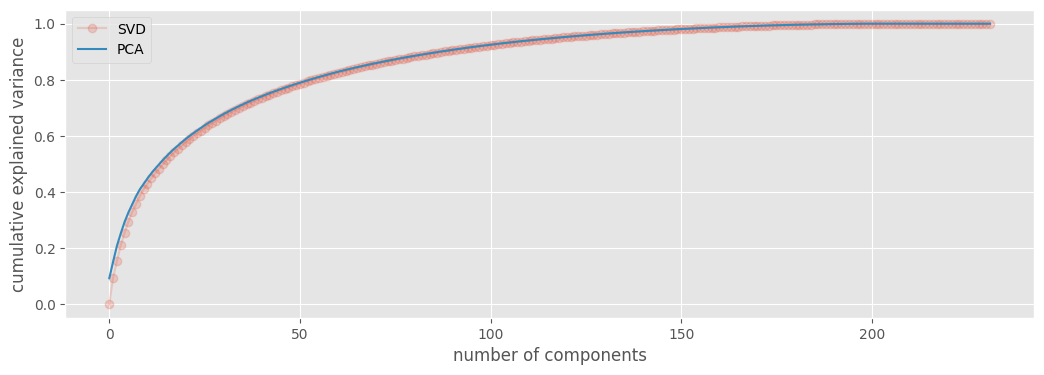

In [23]:
pca = PCA().fit(total_ada_abstract_diluted)
pca_var = np.cumsum(pca.explained_variance_ratio_)

svd_content = TruncatedSVD(n_iter= 25, n_components = 1536 ).fit(total_ada_abstract_diluted)
svd_var = np.cumsum(svd_content.explained_variance_ratio_)
     
plt.figure(figsize = (12.5,4))
plt.plot(svd_var, marker = 'o', alpha =0.2)
plt.plot(pca_var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])

In [24]:
print('PCA 100% :',np.where(np.array(pca_var) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var) >= 0.90)[0][0])
print('SVD 82% :',np.where(np.array(svd_var) >= 0.82)[0][0])
print('SVD 82% :',np.where(np.array(svd_var) >= 0.82)[0][0])

PCA 100% : 165
SVD 100% : 166
PCA 95% : 118
SVD 95% : 119
PCA 90% : 87
SVD 90% : 88
SVD 82% : 59
SVD 82% : 59


In [25]:
pca_reducer(59, total_ada_abstract_diluted, total_ada_title_diluted)
svd_reducer(59, total_ada_abstract_diluted, total_ada_title_diluted)

pca_reducer(87, total_ada_abstract_diluted, total_ada_title_diluted)
svd_reducer(87, total_ada_abstract_diluted, total_ada_title_diluted)

pca_reducer(118, total_ada_abstract_diluted, total_ada_title_diluted)
svd_reducer(118, total_ada_abstract_diluted, total_ada_title_diluted)

pca_reducer(165, total_ada_abstract_diluted, total_ada_title_diluted)
svd_reducer(165, total_ada_abstract_diluted, total_ada_title_diluted)

In [26]:
abstract_pca_59 = np.load('./patent_abst_vectors_norm_pca_59.npy')
abstract_pca_87 = np.load('./patent_abst_vectors_norm_pca_87.npy')
abstract_pca_118 = np.load('./patent_abst_vectors_norm_pca_118.npy')
abstract_pca_165 = np.load('./patent_abst_vectors_norm_pca_165.npy')

abstract_svd_59 = np.load('./patent_abst_vectors_norm_svd_59.npy')
abstract_svd_87 = np.load('./patent_abst_vectors_norm_svd_87.npy')
abstract_svd_118 = np.load('./patent_abst_vectors_norm_svd_118.npy')
abstract_svd_165 = np.load('./patent_abst_vectors_norm_svd_165.npy')

title_pca_59 = np.load('./patent_title_vectors_norm_pca_59.npy')
title_pca_87 = np.load('./patent_title_vectors_norm_pca_87.npy')
title_pca_118 = np.load('./patent_title_vectors_norm_pca_118.npy')
title_pca_165 = np.load('./patent_title_vectors_norm_pca_165.npy')

title_svd_59 = np.load('./patent_title_vectors_norm_svd_59.npy')
title_svd_87 = np.load('./patent_title_vectors_norm_svd_87.npy')
title_svd_118 = np.load('./patent_title_vectors_norm_svd_118.npy')
title_svd_165 = np.load('./patent_title_vectors_norm_svd_165.npy')

In [27]:
searcher_raw = scann.scann_ops_pybind.builder(total_ada_abstract_diluted, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_59 = scann.scann_ops_pybind.builder(abstract_pca_59, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_87 = scann.scann_ops_pybind.builder(abstract_pca_87, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_118 = scann.scann_ops_pybind.builder(abstract_pca_118, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_165 = scann.scann_ops_pybind.builder(abstract_pca_165, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    

searcher_svd_59 = scann.scann_ops_pybind.builder(abstract_svd_59, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_87 = scann.scann_ops_pybind.builder(abstract_svd_87, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_118 = scann.scann_ops_pybind.builder(abstract_svd_118, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    
     
searcher_svd_165 = scann.scann_ops_pybind.builder(abstract_svd_165, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    

In [28]:
raw_idx = []
reduced_idx_pca_59 = []
reduced_idx_svd_59 = []
reduced_idx_pca_87 = []
reduced_idx_svd_87 = []
reduced_idx_pca_118 = []
reduced_idx_svd_118 = []
reduced_idx_pca_165 = []
reduced_idx_svd_165 = []
for i in range(len(total_ada_abstract_diluted)):
    raw_idx.append(searcher_raw.search(total_ada_title_diluted[i])[0])
    reduced_idx_pca_59.append(searcher_pca_59.search(title_pca_59[i])[0])
    reduced_idx_svd_59.append(searcher_svd_59.search(title_svd_59[i])[0])
    reduced_idx_pca_87.append(searcher_pca_87.search(title_pca_87[i])[0])
    reduced_idx_svd_87.append(searcher_svd_87.search(title_svd_87[i])[0])
    reduced_idx_pca_118.append(searcher_pca_118.search(title_pca_118[i])[0])
    reduced_idx_svd_118.append(searcher_svd_118.search(title_svd_118[i])[0])
    reduced_idx_pca_165.append(searcher_pca_165.search(title_pca_165[i])[0])
    reduced_idx_svd_165.append(searcher_svd_165.search(title_svd_165[i])[0])

In [29]:
k = [1,3,5,10,15,20,30]
ap_pca_40, hit_pca_40, mrr_pca_40 = metrics_calculator(raw_idx,reduced_idx_pca_59, k )
ap_svd_40, hit_svd_40, mrr_svd_40 = metrics_calculator(raw_idx,reduced_idx_svd_59, k )

ap_pca_57, hit_pca_57, mrr_pca_57 = metrics_calculator(raw_idx,reduced_idx_pca_87, k )
ap_svd_57, hit_svd_57, mrr_svd_57 = metrics_calculator(raw_idx,reduced_idx_svd_87, k )

ap_pca_90, hit_pca_90, mrr_pca_90 = metrics_calculator(raw_idx,reduced_idx_pca_118, k )
ap_svd_90, hit_svd_90, mrr_svd_90 = metrics_calculator(raw_idx,reduced_idx_svd_118, k )

ap_pca_107, hit_pca_107, mrr_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_165, k )
ap_svd_107, hit_svd_107, mrr_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_165, k )     

<ipython-input-7-79f078fc1687>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


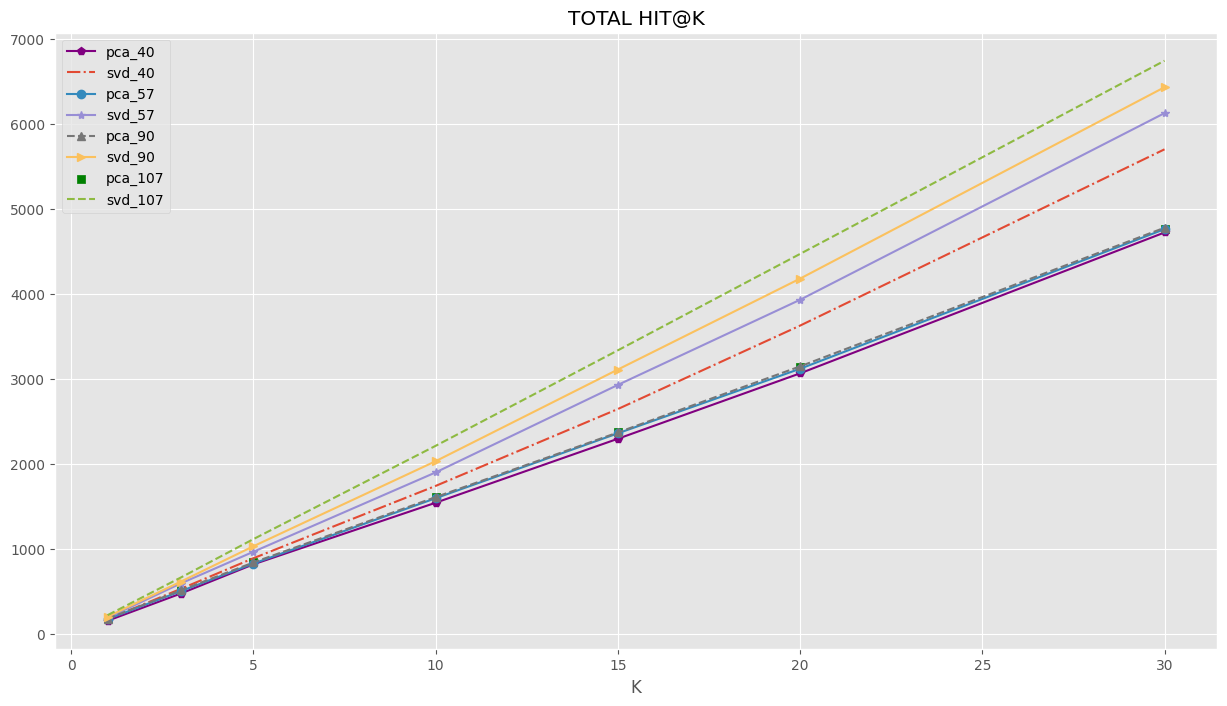

In [34]:




# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_40, '-p', color = 'purple')
plt.plot(k,hit_svd_40, '-.')
plt.plot(k,hit_pca_57, '-o')
plt.plot(k,hit_svd_57, '-*')
plt.plot(k,hit_pca_90, '--^')
plt.plot(k,hit_svd_90, '>-')
plt.scatter(k,hit_pca_107, marker ='s',color= 'green')
plt.plot(k,hit_svd_107, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K')
plt.legend(['pca_40','svd_40','pca_57','svd_57','pca_90','svd_90','pca_107','svd_107'])
plt.xlabel('K');
     

     


In [32]:
len(hit_pca_40)

7

In [33]:
len(raw_idx)

232